<a href="https://colab.research.google.com/github/vsbca/Data-Science/blob/master/Pyspark/Pyspark_EDA_Classficiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
#https://raw.githubusercontent.com/vsbca/Data-Science/master/Data/titanic.csv
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('eda_classification').getOrCreate()

In [ ]:
!wget https://raw.githubusercontent.com/vsbca/Data-Science/master/Data/titanic.csv -O titanic.csv

--2021-08-03 18:25:52--  https://raw.githubusercontent.com/vsbca/Data-Science/master/Data/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60301 (59K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  58.89K  --.-KB/s    in 0.004s  

2021-08-03 18:25:52 (14.5 MB/s) - ‘titanic.csv’ saved [60301/60301]



In [ ]:
df = spark.read.csv("./titanic.csv", header=True, inferSchema=True)
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [ ]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [ ]:
df.count()

891

In [ ]:
len(df.columns)

12

In [ ]:
df.groupBy('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [ ]:
import matplotlib.pyplot as plt

def histogram(df, col, bins=10, xname=None, yname=None):
  '''
  This function makes a histogram from Spark datframe named df
  for column name col
  '''
  #calculating histogram in Spark
  vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)

  #Preprocessing histogram points and locations
  width = vals[0][1] - vals[0][0]
  loc = [vals[0][0] + (i+1)* width for i in range(len(vals[1]))]

  #Making a bar plot
  plt.bar(loc, vals[1], width=width)
  plt.xlabel(col)
  plt.ylabel(yname)
  plt.show()

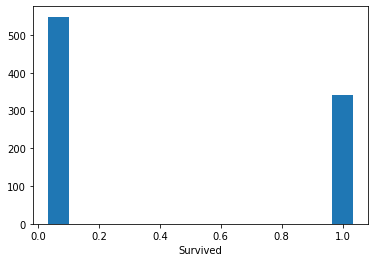

In [ ]:
histogram(df, 'Survived', bins=15)

In [ ]:
#Line plot
def lineplot(df, x, y, measure='mean'):
  '''
    This function makes a line plot from Spark dataframe df with 
    independent variable x and averaged over y.
  '''
  if measure == 'mean':
        
    # Grouping the dataframe by x and averaging over y
    # Sorting is important because Spark shuffle the values 
    # when doing the calculation
        
    pd_df = df.groupBy(x).mean(y).toPandas().sort_values(by=x)
        
    # Making plot using pandas 
    pd_df.plot(x, 'avg({})'.format(y), legend=False)
        
  elif measure == 'total':
    pd_df = df.groupBy(x).sum(y).toPandas().sort_values(by=x)
    pd_df.plot(x, 'sum({})'.format(y), legend=False)
        
  elif measure == 'count':
    pd_df = df.groupBy(x).count().toPandas().sort_values(by=x)
    pd_df.plot(x, 'count', legend=False)
    
  plt.ylabel(y)
  plt.show()

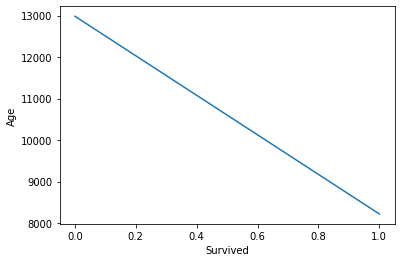

In [ ]:
lineplot(df, 'Survived', 'Age', measure='total')

In [ ]:
def barplot(df, col, lim=10, yname=None):
    
    '''
    This function makes a bar plot for the Spark dataframe df 
    for categorical column col only selecting top categories 
    as specified by lim. 
    '''
    
    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Take first 'lim' number of rows and convert to pandas  
    pd_df = classes.limit(lim).toPandas()
    
    # Making plot 
    pd_df.plot(kind='bar', x=col, legend=False)
    plt.ylabel(yname)
    plt.show()

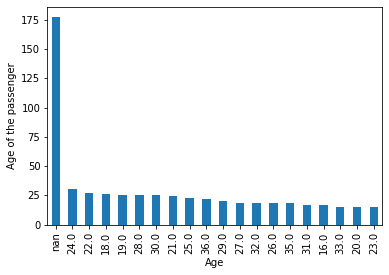

In [ ]:
# Everybody is participating every year (almost)
barplot(df, 'Age', lim=20, yname='Age of the passenger')

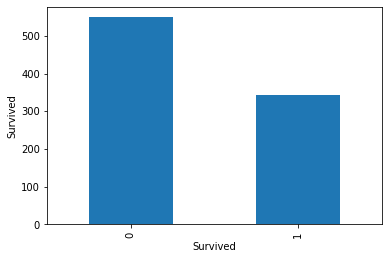

In [ ]:
barplot(df, "Survived", lim=20, yname="Survived")